In [2]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pymc as pm
from scipy.stats import gaussian_kde
plt.style.use('ggplot')

In [3]:
#constants
avg_warriors_fgs = 42.4
warriors_attempted_3 = 2592
warriors_total_attempted_fg = 7159
warriors_free_throws_made = 1366
warriors_free_throws_attempted = 1790

warriors_fg_data = np.array([41,43,46,43,39,46,38,43,36,48,43,43,38,39,47,
                            45,46,39,40,46,35,44,52,42,36,46,42,39,32,43,
                            33,43,43,45,40,46,49,41,42,43,34,46,50,43,44,
                            47,47,42,49,48,44,37,36,42,39,42,53,45,41,47,
                            37,42,47,40,42,47,46,48,31,43,39,43,44,38,39,
                            38,50,49,45,39,34,46])


avg_thunder_fgs = 40.7
thunder_attempted_3 = 1945
thunder_total_attempted_fg = 7082
thunder_free_throws_made = 1616
thunder_free_throws_attempted = 2067
thunder_fg_data = np.array([42,50,45,40,39,38,49,44,39,28,41,38,35,47,42,
                           41,37,37,35,35,47,39,37,35,38,35,46,40,51,37,48,
                           43,42,35,39,38,45,37,39,38,47,40,41,39,45,43,46,
                           48,41,43,44,36,42,45,42,37,43,47,46,47,39,40,32,
                           48,36,31,49,47,45,42,41,45,44,41,31,45,38,46,43,
                           39,42,35])

In [4]:
warriors_mu = pm.Normal('warriors_mu',avg_warriors_fgs,1/16.0)
warriors_tau = 1.0/pm.Uniform('warriors_tau',1,10)**2
warriors_obs = pm.Normal('warriors_obs',warriors_mu,warriors_tau,value=warriors_fg_data,
                        observed=True)

warriors_3_percentage = pm.Beta('warriors_3_percentage',warriors_attempted_3+1,
                               warriors_total_attempted_fg-warriors_attempted_3+1)

warriors_attempted_free_throw = pm.DiscreteUniform('warriors_free_throw',11,33)
warriors_percent_free_throw = pm.Beta('warriors_completed_free_throw',warriors_free_throws_made+1,
                                     warriors_free_throws_attempted-warriors_free_throws_made+1)
warriors_free_throw_binom = pm.Binomial('warriors_free_throw_binom',
                                        warriors_attempted_free_throw,
                                        warriors_percent_free_throw)

@pm.deterministic
def points(warriors_mu = warriors_mu,
          warriors_free_throw_binom=warriors_free_throw_binom,
          warriors_3_percentage=warriors_3_percentage):
    x = warriors_3_percentage
    y = warriors_mu
    return (x*y*3) + (y*(1-x)*2) + warriors_free_throw_binom

warriors_mcmc = pm.MCMC([warriors_mu,warriors_tau,warriors_obs,warriors_attempted_free_throw,
                warriors_percent_free_throw,warriors_free_throw_binom,warriors_3_percentage,
                points])

In [5]:
thunder_mu = pm.Normal('thunder_mu',avg_thunder_fgs,1/25.0)
thunder_tau = 1.0/pm.Uniform('thunder_tau',1,10)**2
thunder_obs = pm.Normal('thunder_obs',thunder_mu,thunder_tau,value=thunder_fg_data,
                       observed=True)

thunder_3_percentage = pm.Beta('thunder_3_percentage',thunder_attempted_3+1,
                              thunder_total_attempted_fg-thunder_attempted_3+1)

thunder_attempted_free_throw = pm.DiscreteUniform('thunder_attempted_free_throw',15,35)
thunder_percent_free_throw = pm.Beta('thunder_completed_free_throw',thunder_free_throws_made+1,
                                    thunder_free_throws_attempted-thunder_free_throws_made+1)
thunder_free_throw_binom = pm.Binomial('thunder_free_throw_binom',thunder_attempted_free_throw,
                                      thunder_percent_free_throw)

@pm.deterministic
def thunder_points(thunder_mu = thunder_mu,
           thunder_free_throw_binom = thunder_free_throw_binom,
           thunder_3_percentage = thunder_3_percentage):
    x = thunder_3_percentage
    y = thunder_mu
    return (x*y*3) + (y*(1-x)*2) + thunder_free_throw_binom

thunder_mcmc = pm.MCMC([thunder_mu,thunder_tau,thunder_obs,thunder_attempted_free_throw,
                       thunder_percent_free_throw,thunder_free_throw_binom,thunder_3_percentage,thunder_points])

In [6]:
warriors_mcmc.sample(50000,10000)
tracer = warriors_mcmc.trace('points')[:]

thunder_mcmc.sample(50000,10000)
thunder_tracer = thunder_mcmc.trace('thunder_points')[:]

 [-----------------100%-----------------] 50000 of 50000 complete in 34.7 sec

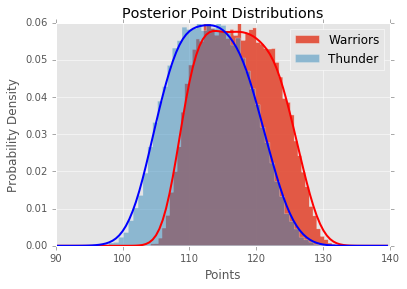

In [7]:
plt.hist(tracer, bins=50, histtype='stepfilled', alpha=0.9, normed=True,label="Warriors")
plt.hist(thunder_tracer,bins=50,histtype='stepfilled',alpha=0.5,normed=True,label="Thunder")
plt.legend(loc='upper right')

density = gaussian_kde(tracer)
density.covariance_factor = lambda : .25
density._compute_covariance()
xs = np.arange(90,140,.5)
ys = density(xs)

thunder_density = gaussian_kde(thunder_tracer)
thunder_density.covariance_factor = lambda : .25
thunder_density._compute_covariance()
thunder_xs = np.arange(90,140,.5)
thunder_ys = thunder_density(thunder_xs)
plt.plot(xs,ys,linewidth=2,color='red')
plt.plot(thunder_xs,thunder_ys,linewidth=2,color='blue')
plt.title('Posterior Point Distributions')
plt.xlabel('Points')
plt.ylabel('Probability Density')
plt.savefig('Posterior_Point_Dists.png')

In [8]:
(tracer > thunder_tracer).mean()

0.69727499999999998

In [9]:
thunder_density.integrate_box_1d(100,120)

0.86709607502248531

In [10]:
a = []
for i in range(len(tracer)):
        a.append(tracer[i]-thunder_tracer[i])
print(sum(a)/len(a))
print(np.std(a))

4.23209870465
7.83941080057


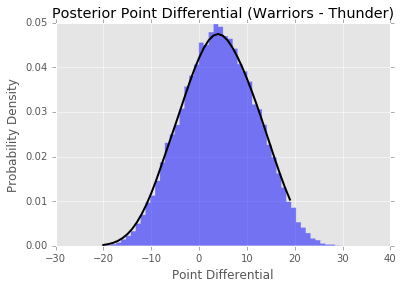

In [11]:
plt.hist(a,bins=50, histtype='stepfilled', alpha=0.5, normed=True,color='blue')
a_density = gaussian_kde(a)
a_density.covariance_factor = lambda : .25
a_density._compute_covariance()
a_xs = np.arange(-20,20,1)
a_ys = a_density(a_xs)
plt.plot(a_xs,a_ys,color='black',linewidth=2)
plt.title('Posterior Point Differential (Warriors - Thunder)')
plt.xlabel('Point Differential')
plt.ylabel('Probability Density')
plt.savefig('Posterior_Point_Diff.png')

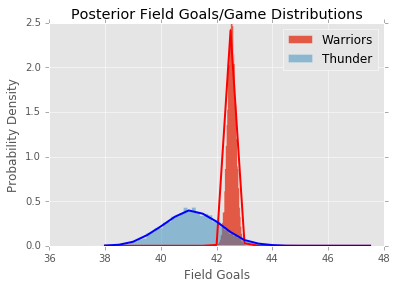

In [12]:
warriors_posterior_mu = warriors_mcmc.trace('warriors_mu')[:]
plt.hist(warriors_posterior_mu,bins=50, histtype='stepfilled', alpha=0.9, normed=True,label='Warriors')
thunder_posterior_mu = thunder_mcmc.trace('thunder_mu')[:]
plt.hist(thunder_posterior_mu,bins=50, histtype='stepfilled', alpha=0.5, normed=True,label='Thunder')

warrior_mu_density = gaussian_kde(warriors_posterior_mu)
warrior_mu_density.covariance_factor = lambda : .25
warrior_mu_density._compute_covariance()
warrior_mu_xs = np.arange(38,48,.5)
warrior_mu_ys = warrior_mu_density(warrior_mu_xs)

thunder_mu_density = gaussian_kde(thunder_posterior_mu)
thunder_mu_density.covariance_factor = lambda : .25
thunder_mu_density._compute_covariance()
thunder_mu_xs = np.arange(38,48,.5)
thunder_mu_ys = thunder_mu_density(thunder_mu_xs)

plt.plot(warrior_mu_xs,warrior_mu_ys,linewidth=2,color='red')
plt.plot(thunder_mu_xs,thunder_mu_ys,linewidth=2,color='blue')
plt.title('Posterior Field Goals/Game Distributions')
plt.xlabel('Field Goals')
plt.ylabel('Probability Density')
plt.legend(loc='upper right')
plt.savefig('Posterior_Field_Goals.png')

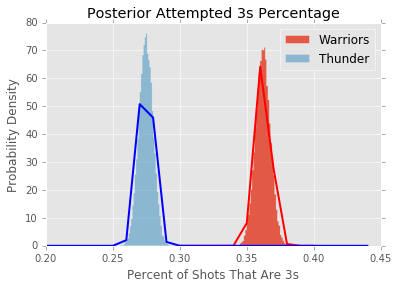

In [13]:
warriors_3s_beta = warriors_mcmc.trace('warriors_3_percentage')[:]
plt.hist(warriors_3s_beta,bins=50, histtype='stepfilled', alpha=0.9, normed=True,label='Warriors')
thunder_3s_beta = thunder_mcmc.trace('thunder_3_percentage')[:]
plt.hist(thunder_3s_beta,bins=50, histtype='stepfilled', alpha=0.5, normed=True,label='Thunder')

warrior_3s_density = gaussian_kde(warriors_3s_beta)
warrior_3s_density.covariance_factor = lambda : .25
warrior_3s_density._compute_covariance()
warrior_3s_xs = np.arange(0.3,0.4,.01)
warrior_3s_ys = warrior_3s_density(warrior_3s_xs)

thunder_3s_density = gaussian_kde(thunder_3s_beta)
thunder_3s_density.covariance_factor = lambda : .25
thunder_3s_density._compute_covariance()
thunder_3s_xs = np.arange(0.2,0.45,0.01)
thunder_3s_ys = thunder_3s_density(thunder_3s_xs)

plt.plot(warrior_3s_xs,warrior_3s_ys,linewidth=2,color='red')
plt.plot(thunder_3s_xs,thunder_3s_ys,linewidth=2,color='blue')
plt.title('Posterior Attempted 3s Percentage')
plt.xlabel('Percent of Shots That Are 3s')
plt.ylabel('Probability Density')
plt.legend(loc='upper right')
plt.savefig('Posterior_Attempted_3s.png')

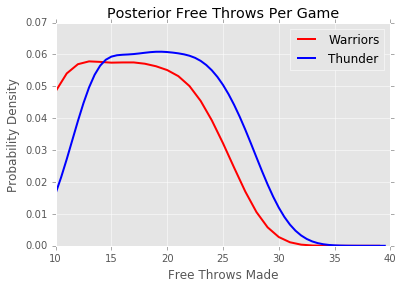

In [14]:
warriors_frees = warriors_mcmc.trace('warriors_free_throw_binom')[:]
#plt.hist(warriors_frees,bins=50, histtype='stepfilled', alpha=0.9, normed=True,label='Warriors')
thunder_frees = thunder_mcmc.trace('thunder_free_throw_binom')[:]
#plt.hist(thunder_frees,bins=50, histtype='stepfilled', alpha=0.5, normed=True,label='Thunder')

warrior_frees_density = gaussian_kde(warriors_frees)
warrior_frees_density.covariance_factor = lambda : .25
warrior_frees_density._compute_covariance()
warrior_frees_xs = np.arange(10,40,1)
warrior_frees_ys = warrior_frees_density(warrior_frees_xs)


thunder_frees_density = gaussian_kde(thunder_frees)
thunder_frees_density.covariance_factor = lambda : .25
thunder_frees_density._compute_covariance()
thunder_frees_xs = np.arange(10,40,.5)
thunder_frees_ys = thunder_frees_density(thunder_frees_xs)

plt.plot(warrior_frees_xs,warrior_frees_ys,linewidth=2,color='red',label="Warriors")
plt.plot(thunder_frees_xs,thunder_frees_ys,linewidth=2,color='blue',label="Thunder")
plt.title('Posterior Free Throws Per Game')
plt.xlabel('Free Throws Made')
plt.ylabel('Probability Density')
plt.legend(loc='upper right')

plt.savefig('Posterior_Free_Throws.png')